If you plan on using this implementation, please cite our work:

@INPROCEEDINGS{Tulczyjew2021IGARSS,
author={Tulczyjew, Lukasz and Nalepa, Jakub},
booktitle={IGARSS 2021 - 2021 IEEE International Geoscience 
and Remote Sensing Symposium},
title={Investigating the impact of the training set size
on deep learning-powered hyperspectral unmixing},
year={2021},
note={in press}}


# Parameters description for the unmixing experiments
Train and evaluate the convolutional neural network (CNN)
as well as the deep convolutional autoencoder (DCAE)
for the unmixing problem. <br><br>
The CNN architecture utilizes several convolutional operations,
concluded with fully-connected layers. The first part could be
treated as a feature extractor, whereas the final segment of
the model, basing on the selected representation, estimates the
abundance for each endmember in the hyperspectral image.
The dropout technique is utilized to prevent from overfitting in
the spectral-spatial variant. Consequently, in the pixel-based approach,
max pooling operations are employed.<br><br>
The DCAE architecture constitutes an autoencoder-powered approach.
The encoding part incorporates several convolutional layers,
whereas the decoder constitutes a single fully-connected layer.
Furthermore, the weights of the decoder are set to the
endmembers matrix of a particular HSI, hence
the condensed representation in the latent space, expresses the abundance
of a particular pixel.<br><br>
Exemplary hyperparameters to set:<br>


- --data-file-path - path to the hyperspectral image (HSI).
- --ground-truth-path - path to the ground truth map containing
the fractions of abundances for entire HSI.
- --train-size - magnitude of the learning set that is utilized
to fine-tune the weights of the model.
- --sub-test-size - size of the test set to evaluate
the generalization of the model. It is sampled from the remaining
HSI excluding the training subset. If not specified, all non-training samples
constitute the test set.<br>Can be employed in the case of experiments
when changing the magnitudes of training sets while keeping the size of testing
sets constant.
- --val-size - fraction or size of the validation subset, it is designed to
monitor the overfitting.
- --channels-idx - index of the spectral dimension in input HSI.
- batch-size - number of samples per update step in the training phase.
- --shuffle - indicates whether to shuffle the dataset in experiment.
- --patience - stopping condition for a specific number of epochs without
improvement.
- --model-name - name of the utilized model, possible values:<br>
unmixing_pixel_based_cnn, unmixing_cube_based_cnn, unmixing_pixel_based_dcae,
unmixing_cube_based_dcae. The *cnn* suffix specifies the CNN architecture,
whereas the *dcae* represents the autoencoder approach. Cube-based variant
incorporates additional features in a form of a spatial extent
of the neighboring pixels of a particular sample, whereas the pixel-based
approach utilizes only the spectral information of a given sample.
- --sample-size - number of spectral bands in a given HSI.
- --neighborhood-size - size of the spatial extent which is employed for each
sample in the form of local neighboring pixels. Most cases allows to leverage
the quality of the segmentation as well as the unmixing.
- --n-classes - number of endmembers in the HSI for which the abundances
will be estimated by the model.
- --lr - learning rate regulates the step size during weights updates in the training phase.
- --epochs - second stopping condition, i.e., the maximum number of epochs.
- --verbose - verbosity mode.
- --save-data - indicates whether to save the training and test data.

# Cube-based DCAE
We specify the necessary parameters for the experiment.

In [1]:
# Execute cube-based DCAE:
from os.path import join

base_path = r'../datasets/urban'
data_file_path = join(base_path, 'urban.npy')
ground_truth_path = join(base_path, 'urban_gt.npy')
endmembers_path = join(base_path, 'urban_m.npy')
train_size = 15500
sub_test_size = 47249
val_size = 0.1
channels_idx = -1
batch_size = 256
shuffle = True
patience = 3
model_name = 'unmixing_cube_based_dcae'
sample_size = 162
neighborhood_size = 5
n_classes = 6
dest_path = join('../examples', 'unmixing_results')
lr = 0.0005
epochs = 10
verbose = 0
save_data = False
use_mlflow = False
seed = 1

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

from ml_intuition import enums
from ml_intuition.data.utils import parse_train_size, subsample_test_set, \
    plot_training_curve, show_statistics
from scripts import prepare_data
from scripts.unmixing import train_unmixing, evaluate_unmixing

os.makedirs(dest_path, exist_ok=True)

dcae_dest_path = join(dest_path, 'cube-based-dcae')
os.makedirs(dcae_dest_path, exist_ok=True)

# Prepare data
We prepare data for the unmixing by utilizing the *prepare_data.main* method.
It accepts various parameters such as path to the data file or ground-truth
for a specific HSI. Furthermore, magnitude of the learning set can be also specified.
Moreover, the method accepts the neighborhood size parameter, which specifies the
spatial extent of each sample. For each run in the experiment, for the
sake of reproducibility, it is possible to set a specific seed.
The returned object is a dictionary with three keys: *train*, *test* and *val*.
Each of them contains an additional dictionary with *data* and *labels* keys,
holding corresponding *numpy.ndarray* objects with the data.
For more details about the parameters, refer to the documentation
of *prepare_data.main* function (located in *scripts/prepare_data*).

In [3]:
# Prepare data for unmixing:
data = prepare_data.main(data_file_path=data_file_path,
                         ground_truth_path=ground_truth_path,
                         train_size=parse_train_size(train_size),
                         val_size=val_size,
                         stratified=False,
                         background_label=-1,
                         channels_idx=channels_idx,
                         neighborhood_size=neighborhood_size,
                         save_data=save_data,
                         seed=seed,
                         use_unmixing=True)
# Subsample the test set to constitute a constant size:
if sub_test_size is not None:
    subsample_test_set(data[enums.Dataset.TEST], sub_test_size)

# Train and evaluate the model
Few parameters previously initialized are employed in this step e.g.,
the name of the model, size of the spectral extent,
learning rate and batch size.
The results including the metrics are stored in *dcae_dest_path* directory.

In [4]:
# Train the model:
train_unmixing.train(model_name=model_name,
                     dest_path=dcae_dest_path,
                     data=data,
                     sample_size=sample_size,
                     neighborhood_size=neighborhood_size,
                     n_classes=n_classes,
                     lr=lr,
                     batch_size=batch_size,
                     epochs=epochs,
                     verbose=verbose,
                     shuffle=shuffle,
                     patience=patience,
                     endmembers_path=endmembers_path,
                     seed=seed)
# Evaluate the model:
evaluate_unmixing.evaluate(
    model_path=os.path.join(dcae_dest_path, model_name),
    data=data,
    dest_path=dcae_dest_path,
    neighborhood_size=neighborhood_size,
    batch_size=batch_size,
    endmembers_path=endmembers_path)
tf.keras.backend.clear_session()

c:\users\łukasz\desktop\machine-learning\venv\lib\site-packages\tensorflow\python\framework\tensor_util.py:125: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  tensor_proto.float_val.extend([np.asscalar(x) for x in proto_values])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 3, 3, 160, 16)     448       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 1, 1, 158, 32)     13856     
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 1, 1, 156, 64)     6208      
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 1, 1, 154, 128)    24704     
_________________________________________________________________
flatten (Flatten)            (None, 19712)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               5046528   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
__________

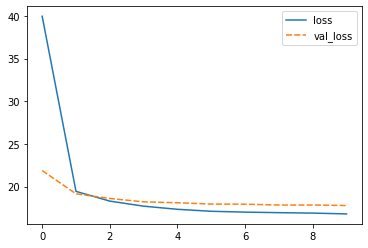

,aRMSE,aSAM,overallRMSE,rmsAAD,perClassSumRMSE,class0RMSE,class1RMSE,class2RMSE,class3RMSE,class4RMSE,class5RMSE,rRMSE,rSID,inference_time
0,0.052665,0.167482,0.080721,0.285665,0.474069,0.085252,0.102679,0.083158,0.052504,0.087284,0.063191,0.060676,3085.67749,28.327313


In [5]:
plot_training_curve(os.path.join(dcae_dest_path, 'training_metrics.csv'),
                    curve_names=['loss', 'val_loss'],
                    y_limit=False)
show_statistics(os.path.join(dcae_dest_path, 'inference_metrics.csv'))

# Pixel-based CNN
We perform the same steps for the pixel-based CNN model, however a few parameters
must be altered. Since we utilize only the spectral dimension, the
*neighborhood_size* is set to *None*, the learning rate is also adjusted.
The *endmembers_path* is also not needed anymore, since we train the
model on the fractions of abundances of each endmember. The pipeline looks similar
to the DCAE model.

In [6]:
# Execute the pixel-based CNN:
endmembers_path = None
model_name = 'unmixing_pixel_based_cnn'
lr = 0.01
neighborhood_size = None
cnn_dest_path = join(dest_path, 'pixel-based-cnn')
os.makedirs(cnn_dest_path, exist_ok=True)

# Prepare data for unmixing:
data = prepare_data.main(data_file_path=data_file_path,
                         ground_truth_path=ground_truth_path,
                         train_size=parse_train_size(train_size),
                         val_size=val_size,
                         stratified=False,
                         background_label=-1,
                         channels_idx=channels_idx,
                         neighborhood_size=neighborhood_size,
                         save_data=save_data,
                         seed=seed,
                         use_unmixing=True)
# Subsample the test set to constitute a constant size:
if sub_test_size is not None:
    subsample_test_set(data[enums.Dataset.TEST], sub_test_size)
# Train the model:
train_unmixing.train(model_name=model_name,
                     dest_path=cnn_dest_path,
                     data=data,
                     sample_size=sample_size,
                     neighborhood_size=neighborhood_size,
                     n_classes=n_classes,
                     lr=lr,
                     batch_size=batch_size,
                     epochs=epochs,
                     verbose=verbose,
                     shuffle=shuffle,
                     patience=patience,
                     endmembers_path=endmembers_path,
                     seed=seed)
# Evaluate the model:
evaluate_unmixing.evaluate(
    model_path=os.path.join(cnn_dest_path, model_name),
    data=data,
    dest_path=cnn_dest_path,
    neighborhood_size=neighborhood_size,
    batch_size=batch_size,
    endmembers_path=endmembers_path)
tf.keras.backend.clear_session()

c:\users\łukasz\desktop\machine-learning\venv\lib\site-packages\tensorflow\python\framework\tensor_util.py:125: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  tensor_proto.float_val.extend([np.asscalar(x) for x in proto_values])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 1, 1, 158, 3)      18        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 1, 1, 79, 3)       0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 1, 1, 76, 6)       78        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 1, 1, 38, 6)       0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 1, 1, 34, 12)      372       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 1, 1, 17, 12)      0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 1, 1, 14, 24)      1176      
__________

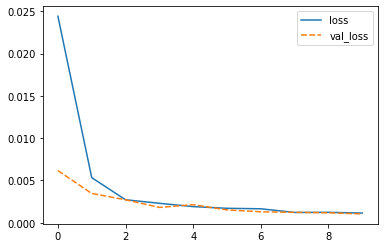

,aRMSE,aSAM,overallRMSE,rmsAAD,perClassSumRMSE,class0RMSE,class1RMSE,class2RMSE,class3RMSE,class4RMSE,class5RMSE,inference_time
0,0.023885,0.073451,0.032043,0.109212,0.189771,0.037084,0.036499,0.033178,0.024482,0.024789,0.033738,1.865043


In [7]:
plot_training_curve(os.path.join(cnn_dest_path, 'training_metrics.csv'),
                    curve_names=['loss', 'val_loss'],
                    y_limit=False)
show_statistics(os.path.join(cnn_dest_path, 'inference_metrics.csv'))
